# Flat prices in Krakow 2024
Project connects **Data Gathering**, **Data Preprocessing**, **Exploratory Data Analysis**, **Machine Learning**, but also using the model inside the application, allowing users to explore it.

![Entry image](images/head-photo.jpg)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_validate, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.svm import SVR

import xgboost as xgb
import tensorflow
from tensorflow import keras

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.titleweight"] = "bold"
sns.set_style("whitegrid")
sns.set_palette("inferno")

In [6]:
colnames = ["Price", "Area", "Ownership", "NRooms", "Status", "Floor", "Balcony", "Terrace", "Garden", "Rent", "Garage", "BuildYear", "Lift", "City", "Longitude", "Latitude"]

In [7]:
df = pd.read_csv("otodom_krk_raw.csv", header=None, names=colnames)
df.head()

,Price,Area,Ownership,NRooms,Status,Floor,Balcony,Terrace,Garden,Rent,Garage,BuildYear,Lift,City,Longitude,Latitude
0,1250000,77.00,-1,3,-1,floor_no::floor_3,0,0,0,500,-1,2007,::n,krakow,19.941979,50.051057
1,932822,60.12,-1,3,construction_status::to_completion,floor_no::floor_1,0,0,1,-1,extras_types-85::garage,2024,::n,krakow,19.881340,50.016400
2,719000,39.00,-1,2,construction_status-67::ready_to_use,floor_no::ground_floor,0,0,0,500,-1,-1,::n,krakow,19.908257,50.020627
3,779000,50.47,-1,3,construction_status-67::ready_to_use,floor_no::floor_4,1,0,0,-1,extras_types-85::garage,1977,::y,krakow,19.927940,50.017480
4,-1,52.48,-1,2,construction_status::to_completion,floor_no::floor_2,1,0,1,-1,extras_types-85::garage,2025,::y,krakow,19.899965,50.084740


In [8]:
df = df.replace("-1", np.nan).replace(-1, np.nan)

# Missing values

The majority of missing values are in **Rent** column, which actually is not that important, so it is going to be dropped.<br>
In terms of the **Price** column - I am going to drop all the rows with missing values there, I don't want to add another noise to the dataset, especially when there is that many of them.<br>
Rows with missing **Balcony**, **Terrace**, **Lift**, **Garage** columns are just indicating that there is a lack of these features in the flat, so I am going to fill them with **0s**.<br>
Missing value for **Ownership** probably tells us that it was obvious for the seller that the ownership is full, so there was no need to state the other way, I am going to fill the missing values with **1s**. The same for **Status** column.<br>
**BuildYear's** missing values are going to be filled with grouped correlated values created by some sort of **Imputer**.

---

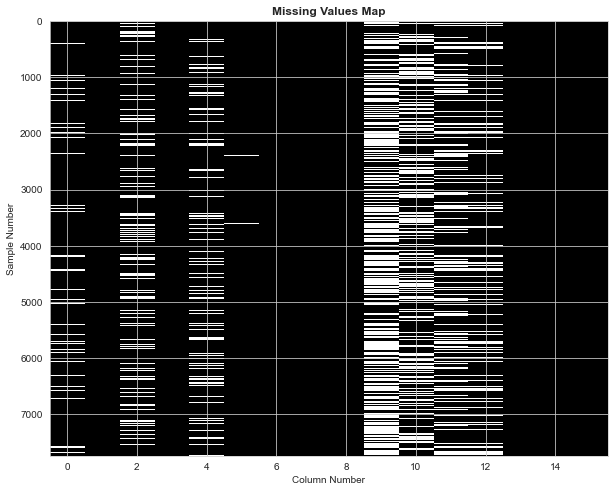

In [9]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");
plt.title("Missing Values Map", weight="bold")
plt.show()

### Rent column
---

In [10]:
df = df.drop("Rent", axis=1)

### Price column
---

In [11]:
df = df[~df["Price"].isna()]

### Lift column
---

In [12]:
df["Lift"] = df["Lift"].fillna("0").replace("::y", "1").replace("::n", "0")

### Garage column
---

In [13]:
df["Garage"] = df["Garage"].fillna("0").replace("extras_types-85::garage", "1")

### Ownership column
---

In [14]:
df["Ownership"] = df["Ownership"].fillna("1").apply(lambda x: "1" if x == "building_ownership::full_ownership" else "0")

### Status column
---

In [15]:
df["Status"] = df["Status"].fillna("1").apply(lambda x: "1" if x == "construction_status-67::ready_to_use" else "0")

### Floor column
---

In [16]:
def convert_floor(floor_string: str) -> str:
    try:
        res = floor_string[10:]
        if res in ["floor_10", "floor_higher_10", "garret"]:
            return "10"
        elif res == "ground_floor":
            return "0"
        else:
            return res[6:]
    except:
        return floor_string

In [17]:
df["Floor"] = df["Floor"][~df["Floor"].isin(["floor_no::cellar"])].apply(lambda x: convert_floor(x))

In [18]:
df = df[~df["Floor"].isna()]

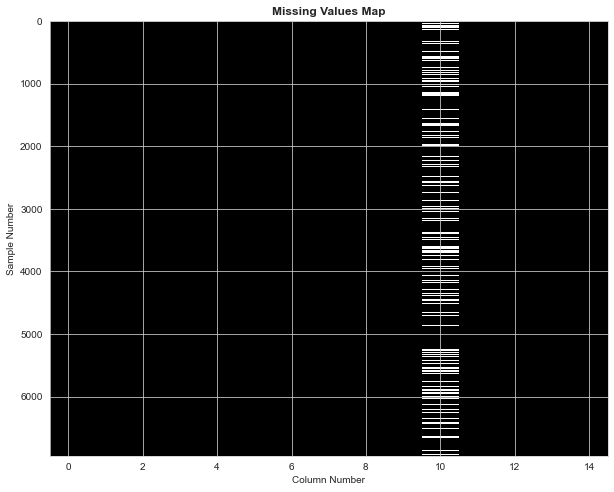

In [19]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");
plt.title("Missing Values Map", weight="bold")
plt.show()

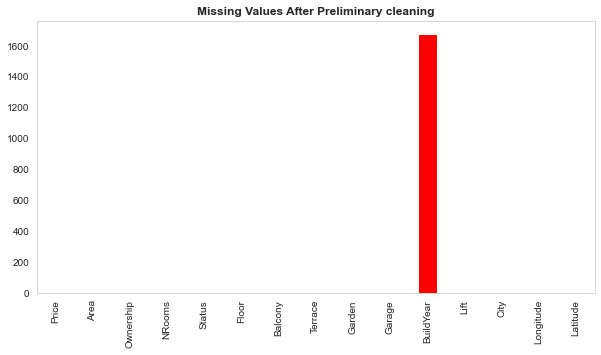

In [20]:
plt.figure(figsize=(10,5))
df.isna().sum().plot(kind="bar", color="red")
plt.title("Missing Values After Preliminary cleaning", weight="bold")
plt.grid()
plt.show()

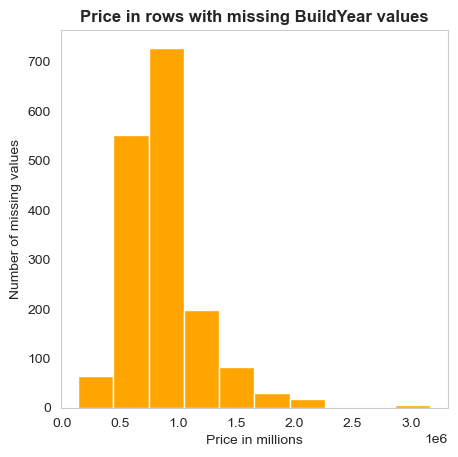

In [21]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)

df[df["BuildYear"].isna()]["Price"].plot(kind="hist", ax=ax, color="orange")
ax.grid()
ax.set_xlabel("Price in millions")
ax.set_ylabel("Number of missing values")
ax.set_title("Price in rows with missing BuildYear values", weight="bold")
plt.show()

# Let's have a little insight on the data

Before I decide what to really do with **BuildYear** missing values, I need to see how the data looks like a little bit.

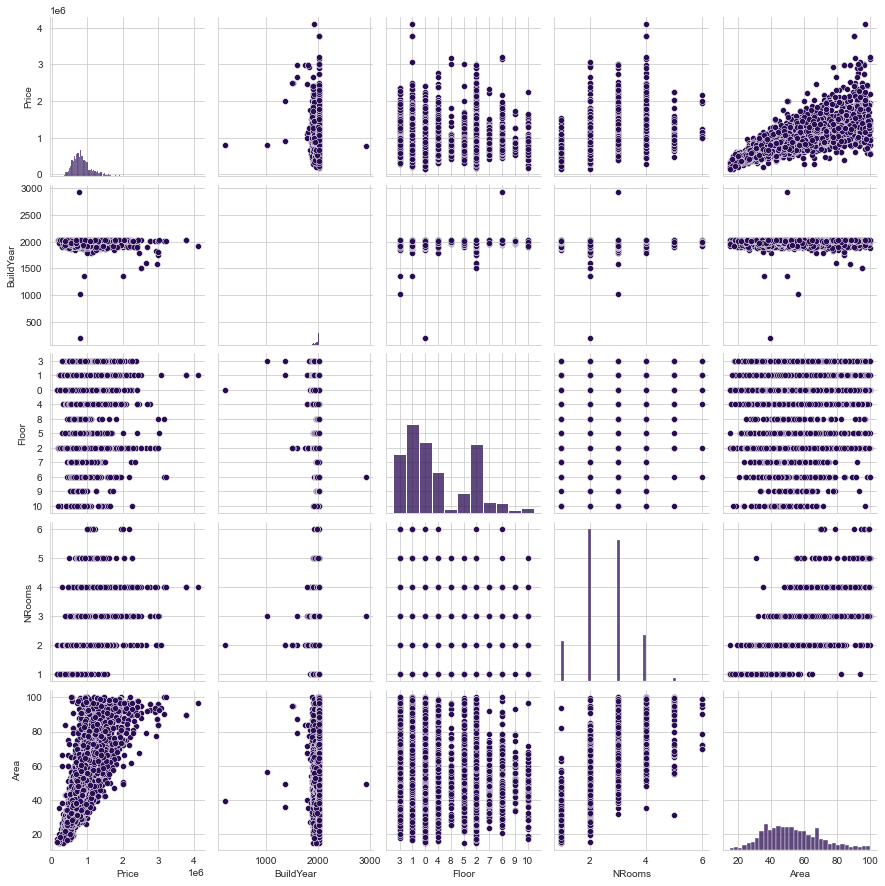

In [22]:
sns.pairplot(df, vars=["Price", "BuildYear", "Floor", "NRooms", "Area"])
plt.show()

# First steps
The key insights gathered from a simple visualization for each feature:<br>
- **Price**:<br>
&emsp; I need to take care of outliers, especially knowing that I want my model to be created for prices not higher than 1.5m, I should also check the lower values that are biased.
- **BuildYear**:<br>
&emsp; Apart from imputing missing data, I can see huge outliers in both directions, It would be probably a good choice to put the values into buckets rather than leave the years alone.
- **Floor**:<br>
&emsp; Higher floors are the minority in the dataset, I should probably put all of them into one bucket.
- **NRooms**:<br>
&emsp; There are only a few instances of flats with 5 or 6 rooms, I should think about the solution for this problem (bucketing or dropping)
- **Area**:<br>
&emsp; Area is filtered right-away by the site filters, however I need to fix the Area-NRooms correlation, where I can see interesting outliers.
---

## Price
---

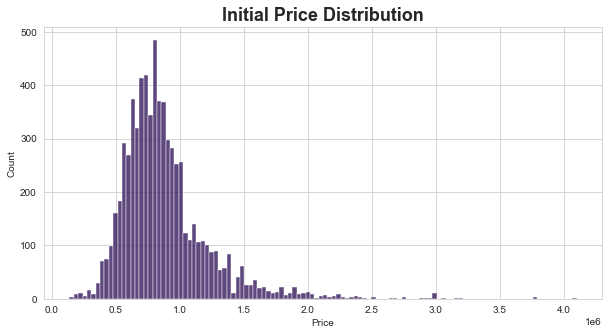

In [23]:
sns.histplot(data=df, x="Price")
plt.title("Initial Price Distribution", weight="bold", fontsize=18)
plt.show()

In [24]:
no_more_1500k = df[df["Price"] > 1500000]
no_less_150k  = df[df["Price"] < 150000]
print(f"There are {no_more_1500k.shape[0]} records with price higher than 1.5m")
print(f"There are {no_less_150k.shape[0]} records with price less than 150k")

There are 355 records with price higher than 1.5m
There are 3 records with price less than 150k


In [25]:
df = df[(df["Price"] >= 150000) & (df["Price"] <= 1500000)]

In [26]:
df.shape[0]

6586

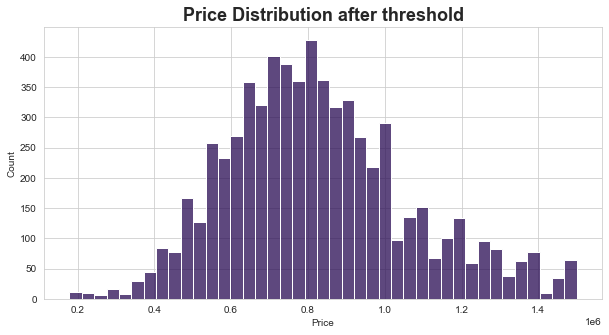

In [27]:
sns.histplot(data=df, x="Price")
plt.title("Price Distribution after threshold", weight="bold", fontsize=18)
plt.show()

## Floor
---

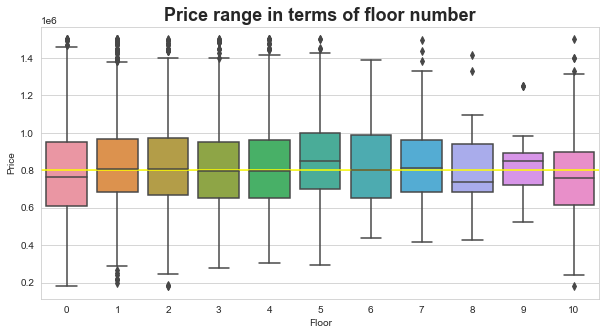

In [28]:
sns.boxplot(data=df, x="Floor", y="Price", order=sorted(df["Floor"].unique(), key=lambda x: int(x)))
plt.title("Price range in terms of floor number", weight="bold", fontsize=18)
plt.axhline(y=df["Price"].median(), color="yellow")
plt.show()

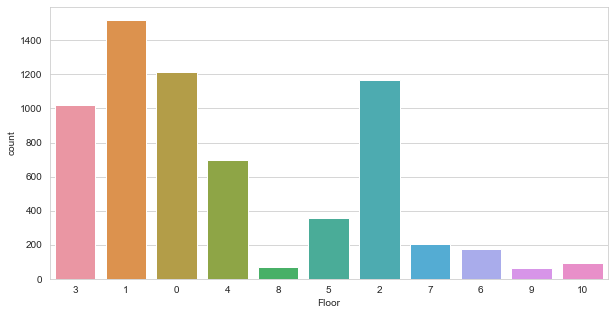

In [29]:
sns.countplot(data=df, x="Floor")
plt.show()

### NRooms
---

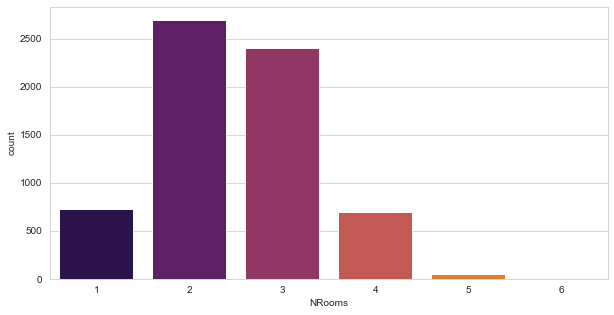

In [30]:
sns.countplot(data=df, x="NRooms")
plt.show()

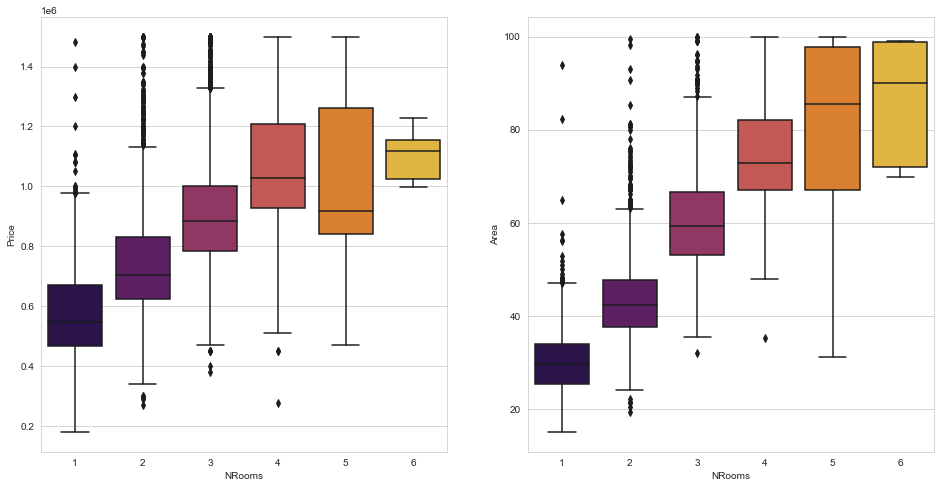

In [31]:
fig, axes = plt.subplots(figsize=(16, 8), ncols=2)

sns.boxplot(data=df, x="NRooms", y="Price", ax=axes[0])
sns.boxplot(data=df, x="NRooms", y="Area", ax=axes[1])
plt.show()

In [32]:
df["Ownership"] = df["Ownership"].astype("int")
df["Status"] = df["Status"].astype("int")
df["Floor"] = df["Floor"].astype("int")
df["Lift"] = df["Lift"].astype("int")

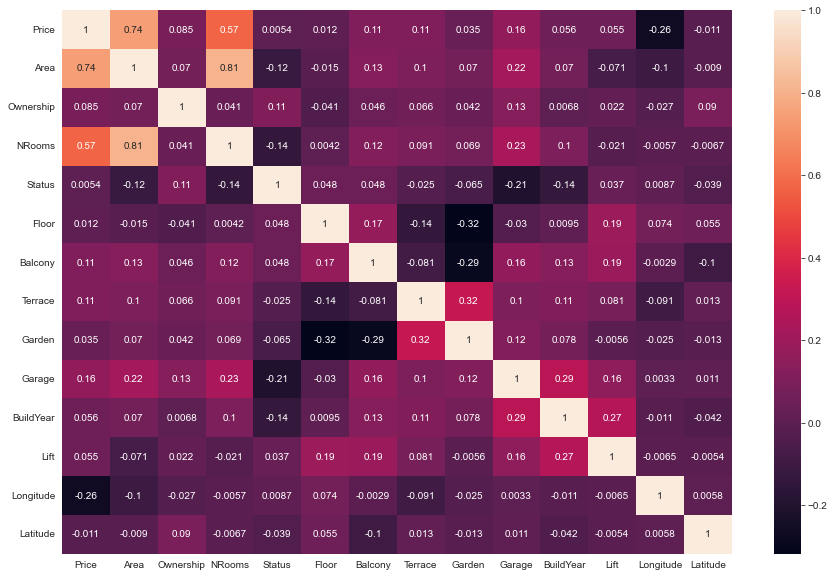

In [33]:
plt.figure(figsize=(15,10))
df["Garage"] = df["Garage"].astype("int")
sns.heatmap(df.corr(), annot=True)
plt.show()

### BuildYear
---

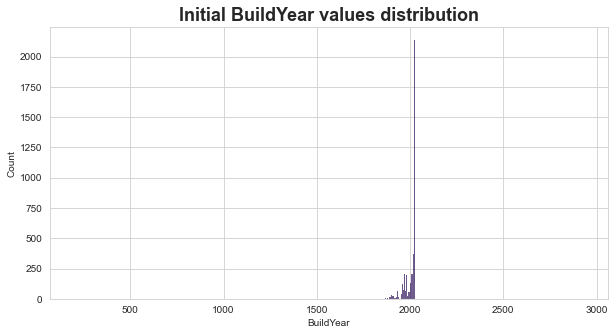

In [34]:
sns.histplot(data=df, x="BuildYear")
plt.title("Initial BuildYear values distribution", weight="bold", fontsize=18)
plt.show()

In [35]:
df.loc[df["BuildYear"] > 2024, "BuildYear"] = 2024

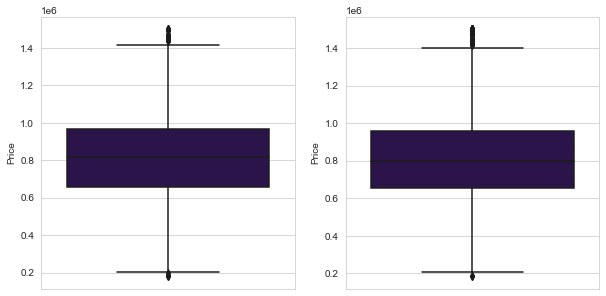

In [36]:
fig, axes = plt.subplots(ncols=2)

sns.boxplot(data=df[df["BuildYear"].isna()], y="Price", ax=axes[0])
sns.boxplot(data=df[~df["BuildYear"].isna()], y="Price", ax=axes[1])
plt.show()

In [37]:
df = df[(df["BuildYear"] > 1850) | (df["BuildYear"].isna())]
df.shape

(6577, 15)

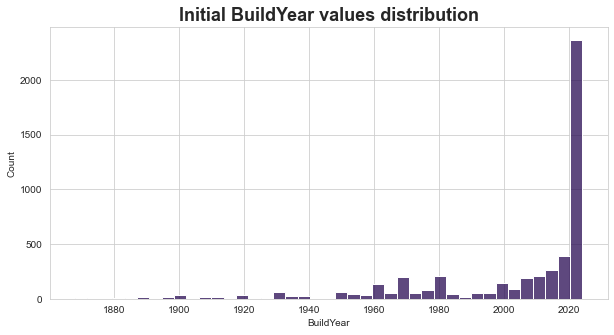

In [38]:
sns.histplot(data=df, x="BuildYear")
plt.title("Initial BuildYear values distribution", weight="bold", fontsize=18)
plt.show()

# Creating a simple model in order to impute BuildYear

I will try to make a simple linear model basing on the most correlated features to impute BuildYear. 

I am going to use:
- **Garage** (0.29)
- **Lift** (0.27)
- **Balcony** (0.13)
- **Terrace** (0.11)

 ---

In [39]:
X_lr = df.loc[~df["BuildYear"].isna(), ["Garage", "Balcony", "Terrace", "Lift", "NRooms"]].values
y_lr = df.loc[~df["BuildYear"].isna(), ["BuildYear"]].values

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.1, random_state=42)

lr = LinearRegression()
cv_ridge = GridSearchCV(Ridge(),
                        {"alpha": [0.01, 0.05, 0.1, 0.15, 0.2]},
                        cv=10,
                        scoring="neg_root_mean_squared_error")

cv_lasso = GridSearchCV(Lasso(),
                        {"alpha": [0.01, 0.05, 0.1, 0.15, 0.2]},
                        cv=10,
                        scoring="neg_root_mean_squared_error")

cv_tree = GridSearchCV(DecisionTreeRegressor(),
                       {"max_depth": [6, 8, 10, 12, 14, 16, 24, 32, 48]},
                       cv=10,
                       scoring="neg_root_mean_squared_error")

cv_ridge.fit(X_lr, y_lr)
cv_lasso.fit(X_lr, y_lr)
cv_tree.fit(X_lr, y_lr)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10, 12, 14, 16, 24, 32, 48]},
             scoring='neg_root_mean_squared_error')

In [40]:
print("Linear Regression")
print(np.mean(-cross_val_score(lr, X_lr, y_lr, scoring="neg_mean_absolute_error", cv=10)))
print(np.mean(-cross_val_score(lr, X_lr, y_lr, scoring="neg_root_mean_squared_error", cv=10)), "\n")

print("Ridge")
print(np.mean(-cross_val_score(cv_ridge.best_estimator_, X_lr, y_lr, scoring="neg_mean_absolute_error", cv=10)))
print(np.mean(-cross_val_score(cv_ridge.best_estimator_, X_lr, y_lr, scoring="neg_root_mean_squared_error", cv=10)), "\n")

print("Lasso")
print(np.mean(-cross_val_score(cv_lasso.best_estimator_, X_lr, y_lr, scoring="neg_mean_absolute_error", cv=10)))
print(np.mean(-cross_val_score(cv_lasso.best_estimator_, X_lr, y_lr, scoring="neg_root_mean_squared_error", cv=10)), "\n")

print("Decision Tree")
print(np.mean(-cross_val_score(cv_tree.best_estimator_, X_lr, y_lr, scoring="neg_mean_absolute_error", cv=10)))
print(np.mean(-cross_val_score(cv_tree.best_estimator_, X_lr, y_lr, scoring="neg_root_mean_squared_error", cv=10)), "\n")

Linear Regression
17.84530488677494
25.26602597320565 

Ridge
17.84538395148594
25.266014408756757 

Lasso
17.84421637555234
25.26598040101391 

Decision Tree
16.933758058650263
24.960856318740372 



In [41]:
lr.fit(X_train_lr, y_train_lr)
y_pred_lr = lr.predict(X_test_lr)
y_pred_lr[y_pred_lr > 2024] = 2024
mean_absolute_error(y_test_lr, y_pred_lr)
#root_mean_squared_error(y_test_lr, y_pred_lr)

17.592150879220853

In [42]:
tree = cv_tree.best_estimator_
tree.fit(X_train_lr, y_train_lr)
y_pred_tree = tree.predict(X_test_lr)
y_pred_tree[y_pred_tree > 2024] = 2024
mean_absolute_error(y_test_lr, y_pred_tree)
#root_mean_squared_error(y_test_lr, y_pred_tree)

16.916874726500925

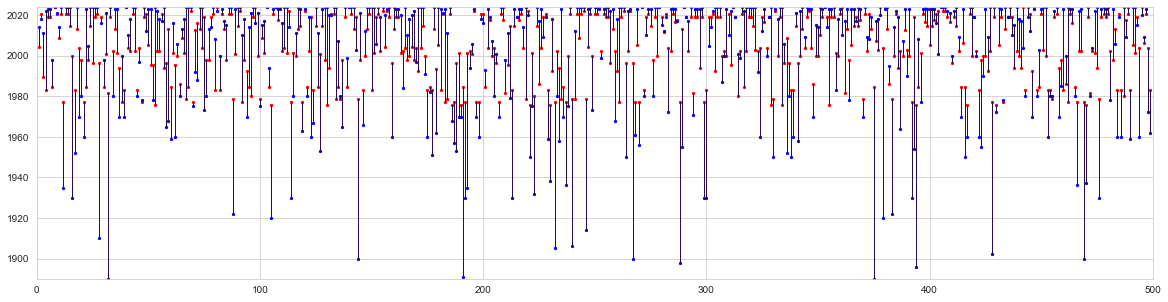

In [43]:
def plot_residual_error(y_test: np.array, y_pred: np.array, colors: list = ["red", "blue"], points: bool = True, lines: bool = True, linewidth: int = 1) -> None:
    points = True if not lines else points
    y_pred = y_pred.reshape(-1, 1)
    size = y_test.shape[0]

    y_lims = [min(np.min(y_pred), np.min(y_test)), max(np.max(y_pred), np.max(y_test))]
    x_lims = [0, size + 1]

    y_range = y_lims[1] - y_lims[0]

    plt.figure(figsize=(20,5))
    if points:
        plt.scatter(np.arange(1, size+1), y_pred, c=colors[0], s=5)
        plt.scatter(np.arange(1, size+1), y_test, c=colors[1], s=5)
    plt.ylim(y_lims)
    plt.xlim(x_lims)
    if lines:
        y_pred = y_pred.flatten()
        y_test = y_test.flatten()
        for i in range(1, size+1):
            yp = y_pred[i-1]
            yt = y_test[i-1]
                
            
            plt.axvline(x=i,
                        ymin=(min(yp, yt)-y_lims[0])/y_range,
                        ymax=(max(yp, yt)-y_lims[0])/y_range,
                        linewidth=linewidth)

    plt.show()
    
plot_residual_error(y_test_lr, y_pred_lr, points=True, linewidth=1)

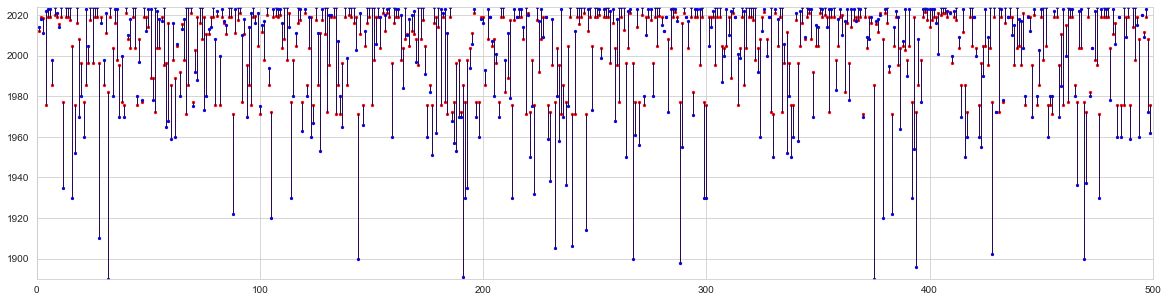

In [44]:
plot_residual_error(y_test_lr, y_pred_tree)

In [45]:
df.loc[df["BuildYear"].isna(), "BuildYear"] = tree.predict(df[df["BuildYear"].isna()][["Garage", "Balcony", "Terrace", "Lift", "NRooms"]].values)

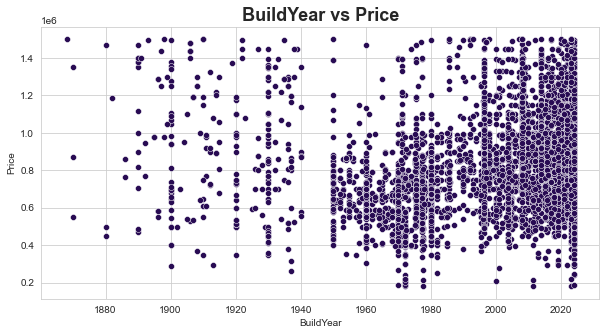

In [46]:
sns.scatterplot(data=df, x="BuildYear", y="Price")
plt.title("BuildYear vs Price", weight="bold", fontsize=18)
plt.show()

In [47]:
df["Age"] = pd.cut(df["BuildYear"], bins=[1850, 2000, 2016, 2024], labels=[0, 1, 2])

In [48]:
df["Age"].value_counts()

2    2936
0    2181
1    1460
Name: Age, dtype: int64

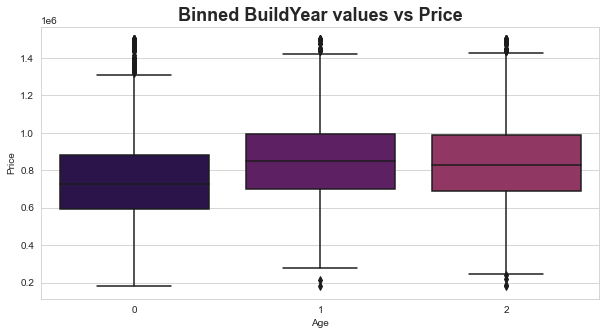

In [49]:
sns.boxplot(data=df, x="Age", y="Price")
plt.title("Binned BuildYear values vs Price", weight="bold", fontsize=18)
plt.show()

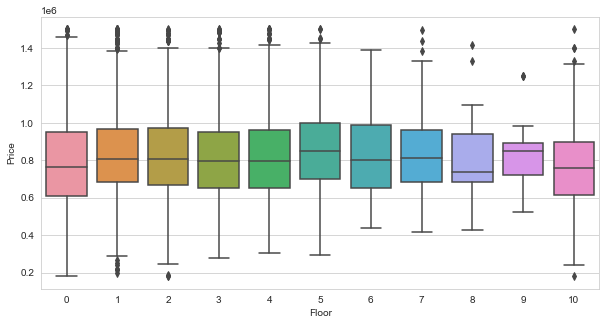

In [50]:
sns.boxplot(data=df, x="Floor", y="Price")
plt.show()

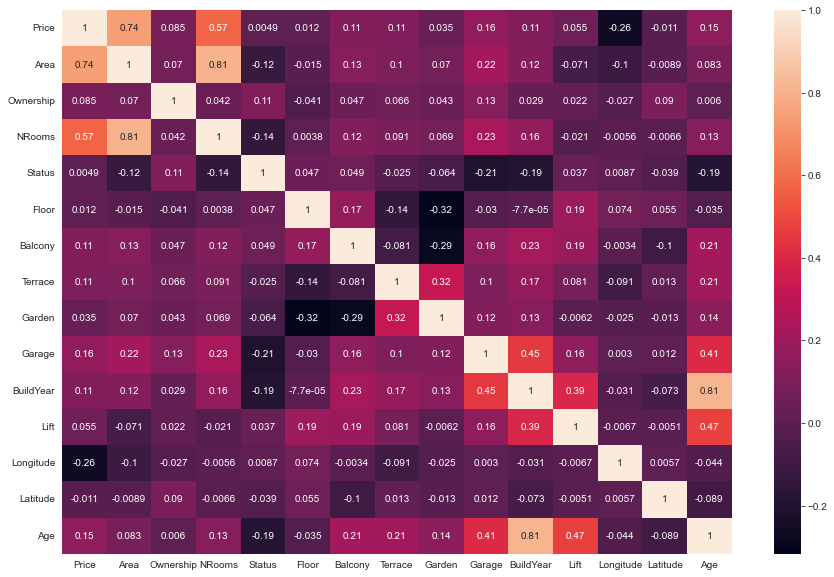

In [51]:
plt.figure(figsize=(15,10))
df["Age"] = df["Age"].astype("int")
sns.heatmap(df.corr(), annot=True)
plt.show()

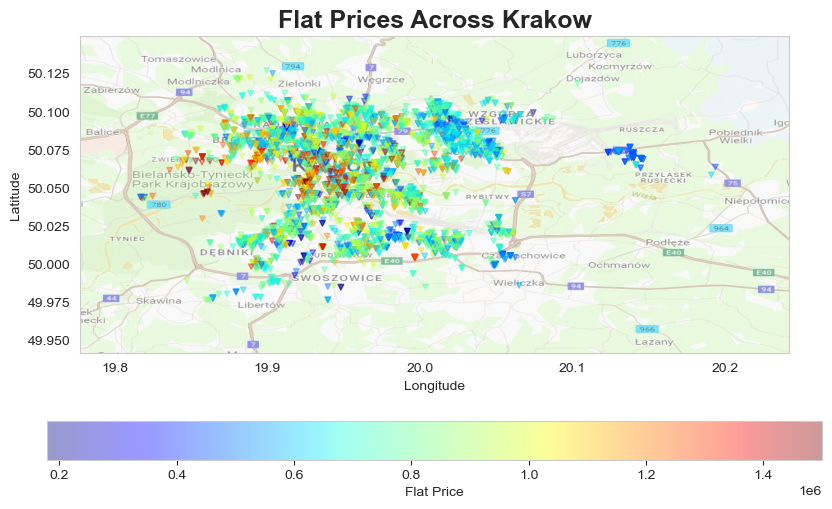

In [91]:
import cv2

krakow_map = cv2.imread("images/krk1.jpg")
plt.rcParams['axes.grid'] = False
plt.figure(figsize=(10,6), dpi=100)
plt.imshow(krakow_map, extent=[19.777, 20.2423, 49.9417, 50.1497], alpha=0.7)
plt.scatter(df["Longitude"], df["Latitude"], alpha=0.4, c=df["Price"], cmap="jet", s=16, marker="v")

plt.title("Flat Prices Across Krakow", weight="bold", fontsize=18)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(orientation="horizontal", label="Flat Price")
plt.savefig("images/head-photo.jpg")
plt.show()

In [54]:
df["Floor"].value_counts()

1     1518
0     1214
2     1164
3     1016
4      699
5      359
7      207
6      175
10      93
8       71
9       61
Name: Floor, dtype: int64

# Modeling

---

In [75]:
features = ["Area", "Ownership", "NRooms", "Status", "Floor", "Balcony", "Terrace", "Garden", "Garage", "Lift", "Longitude", "Latitude", "Age"]

In [59]:
def print_results(y_test: np.array, y_pred: np.array, name: str = "Model") -> None:
    """
    Prints the results for the model predicted values.
    """
    print(f"**--- Results for {name} ---**")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("RMSE:", root_mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("--- --- ---")
    

def check_model(model, X: np.array, y: np.array, name: str = "Model") -> None:
    """
    Prints the cross-validated results for given model.
    """
    scoring = {
        "R2": "r2",
        "RMSE": "neg_root_mean_squared_error",
        "MAE": "neg_mean_absolute_error"
    }
    
    scores = cross_validate(model, X, y, scoring=scoring)
    
    print(f"**--- Results for {name} ---**")
    print("R2 Score:", np.mean(scores["test_R2"]))
    print("RMSE:", np.mean(-scores["test_RMSE"]))
    print("MAE:", np.mean(-scores["test_MAE"]))
    print("**--- --- ---**")

In [60]:
X = df.drop(["Price", "BuildYear", "City"], axis=1).values
y = np.ravel(df[["Price"]].values)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6577 entries, 0 to 7738
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      6577 non-null   float64
 1   Area       6577 non-null   float64
 2   Ownership  6577 non-null   int32  
 3   NRooms     6577 non-null   int64  
 4   Status     6577 non-null   int32  
 5   Floor      6577 non-null   int32  
 6   Balcony    6577 non-null   int64  
 7   Terrace    6577 non-null   int64  
 8   Garden     6577 non-null   int64  
 9   Garage     6577 non-null   int32  
 10  BuildYear  6577 non-null   float64
 11  Lift       6577 non-null   int32  
 12  City       6577 non-null   object 
 13  Longitude  6577 non-null   float64
 14  Latitude   6577 non-null   float64
 15  Age        6577 non-null   int32  
dtypes: float64(5), int32(6), int64(4), object(1)
memory usage: 719.4+ KB


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
lr = LinearRegression()
rf = RandomForestRegressor()
svr = SVR()
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor()

models = {"Linear Regression": lr, "Random Forest": rf, "Support Vector Machines": svr,
          "Gradient Boost": gb, "AdaBoost": ada}

for name, model in models.items():
    check_model(model, X, y, name)

**--- Results for Linear Regression ---**
R2 Score: 0.6036115753961376
RMSE: 150895.86515073612
MAE: 110753.26137258636
**--- --- ---**
**--- Results for Random Forest ---**
R2 Score: 0.8468903974537426
RMSE: 93740.072078058
MAE: 57548.99872822367
**--- --- ---**
**--- Results for Support Vector Machines ---**
R2 Score: -0.011328160633499262
RMSE: 241134.82813659095
MAE: 186894.1916124777
**--- --- ---**
**--- Results for Gradient Boost ---**
R2 Score: 0.8002961328932194
RMSE: 107107.2880079919
MAE: 74639.56305818274
**--- --- ---**
**--- Results for AdaBoost ---**
R2 Score: 0.5968750742078978
RMSE: 152169.78228760796
MAE: 123026.66440379068
**--- --- ---**


### Evaluating on test set
**Random Forest Regressor** did pretty good in cross-validation tests, I am going to hypertune this model, however let's first see how it performs on previously selected dataset.

---

In [65]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print_results(y_test, y_pred, "Random Forest")

**--- Results for Random Forest ---**
R2 Score: 0.8578076233108162
RMSE: 91054.44773421618
MAE: 56408.598394035886
--- --- ---


### Model works quite good on average prices, however it has problems with edgey values

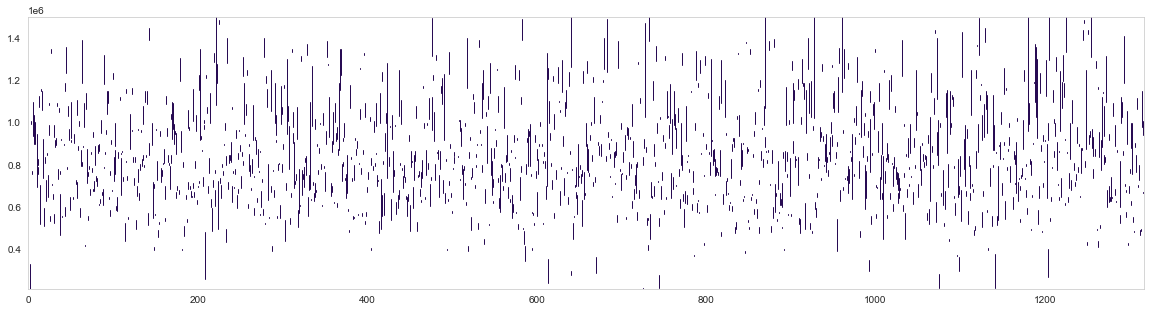

In [66]:
plot_residual_error(y_test, y_pred, points=False)

# Random Forest Hypertuning

I will try to improve model performance with **GridSearchCV**.

---

In [67]:
params = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [4, 6, 8]
}

rf_cv = GridSearchCV(RandomForestRegressor(random_state=42, oob_score=True),
                     params,
                     scoring="neg_root_mean_squared_error",
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_root_mean_squared_error')

In [68]:
model1 = rf_cv.best_estimator_
print(-rf_cv.best_score_)
print(rf_cv.best_params_)

109756.71467734213
{'max_depth': 8, 'n_estimators': 100}


In [69]:
params = {
    "n_estimators": [100, 200],
    "max_depth": [8, 12, 14, 16, 18]
}

rf_cv = GridSearchCV(RandomForestRegressor(random_state=42, oob_score=True),
                     params,
                     scoring="neg_root_mean_squared_error",
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 12, 14, 16, 18],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [70]:
model1 = rf_cv.best_estimator_
print(-rf_cv.best_score_)
print(rf_cv.best_params_)

97673.58327842876
{'max_depth': 18, 'n_estimators': 200}


In [71]:
params = {
    "n_estimators": [200, 250],
    "max_depth": [18, 20, 22, 24, 26]
}

rf_cv = GridSearchCV(RandomForestRegressor(random_state=42, oob_score=True),
                     params,
                     scoring="neg_root_mean_squared_error",
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [18, 20, 22, 24, 26],
                         'n_estimators': [200, 250]},
             scoring='neg_root_mean_squared_error')

In [72]:
model1 = rf_cv.best_estimator_
print(-rf_cv.best_score_)
print(rf_cv.best_params_)

97576.56624645846
{'max_depth': 20, 'n_estimators': 200}


In [73]:
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
print_results(y_test, y_pred)

**--- Results for Model ---**
R2 Score: 0.8606409729837899
RMSE: 90142.69970112153
MAE: 55929.7953690261
--- --- ---


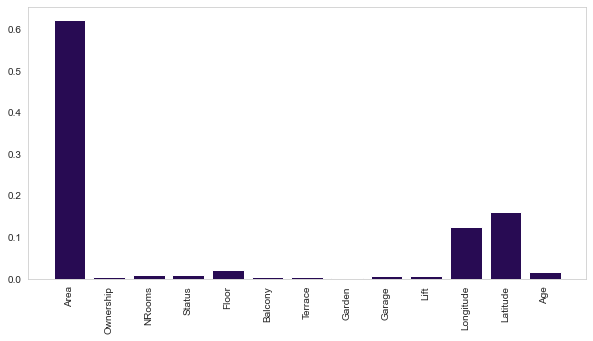

In [76]:
plt.bar(np.arange(1, 14), (model1.feature_importances_))
plt.xticks(np.arange(1, 14), features, rotation='vertical')
plt.show()

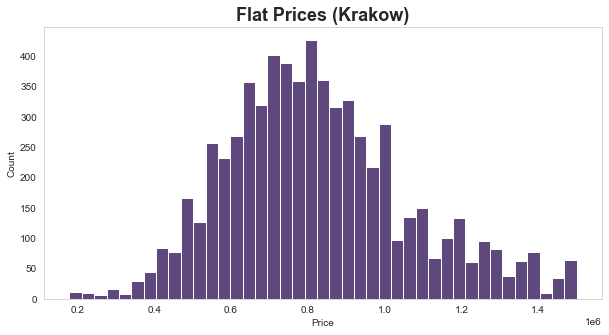

In [77]:
sns.histplot(data=df, x="Price")
plt.title("Flat Prices (Krakow)", weight="bold", fontsize=18)
plt.show()

### XGBoost
---
I want to check how the **XGBoost** will manage with this particular dataset. Looking at the un-tuned model, It is really close to **Random Forest** results.

In [78]:
xboost = xgb.XGBRegressor()

check_model(xboost, X, y, "XGBoost")

**--- Results for XGBoost ---**
R2 Score: 0.8529483241449988
RMSE: 91913.22365006273
MAE: 60072.976490887595
**--- --- ---**


In [79]:
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [80]:
xboost_1 = xgb.XGBRegressor(n_estimators=600, early_stopping_rounds=30, eval_metric=mean_absolute_error)
xboost_1.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)])

[0]	validation_0-rmse:191825.12615	validation_0-mean_absolute_error:148432.34375
[1]	validation_0-rmse:158653.80165	validation_0-mean_absolute_error:121127.82031
[2]	validation_0-rmse:138478.26218	validation_0-mean_absolute_error:104422.21875
[3]	validation_0-rmse:125529.20202	validation_0-mean_absolute_error:93239.56250
[4]	validation_0-rmse:117760.75707	validation_0-mean_absolute_error:85864.00000
[5]	validation_0-rmse:113065.05271	validation_0-mean_absolute_error:80824.82812
[6]	validation_0-rmse:109850.48516	validation_0-mean_absolute_error:77372.34375
[7]	validation_0-rmse:107298.02167	validation_0-mean_absolute_error:74679.13281
[8]	validation_0-rmse:105853.53765	validation_0-mean_absolute_error:73113.27344
[9]	validation_0-rmse:104466.77350	validation_0-mean_absolute_error:71512.75000
[10]	validation_0-rmse:104291.30754	validation_0-mean_absolute_error:71229.24219
[11]	validation_0-rmse:103673.06641	validation_0-mean_absolute_error:70431.04688
[12]	validation_0-rmse:102710.50031

[103]	validation_0-rmse:92456.52987	validation_0-mean_absolute_error:61461.20312
[104]	validation_0-rmse:92340.40378	validation_0-mean_absolute_error:61354.10156
[105]	validation_0-rmse:92328.83279	validation_0-mean_absolute_error:61301.57031
[106]	validation_0-rmse:92409.90363	validation_0-mean_absolute_error:61343.24219
[107]	validation_0-rmse:92356.47509	validation_0-mean_absolute_error:61305.82422
[108]	validation_0-rmse:92402.79376	validation_0-mean_absolute_error:61235.98047
[109]	validation_0-rmse:92346.70957	validation_0-mean_absolute_error:61179.11719
[110]	validation_0-rmse:92193.69720	validation_0-mean_absolute_error:61068.63672
[111]	validation_0-rmse:92152.32885	validation_0-mean_absolute_error:61048.44531
[112]	validation_0-rmse:92118.71062	validation_0-mean_absolute_error:61006.88281
[113]	validation_0-rmse:92156.79961	validation_0-mean_absolute_error:61012.33594
[114]	validation_0-rmse:92233.17926	validation_0-mean_absolute_error:61117.25391
[115]	validation_0-rmse:9223

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x0000016790CF3A60>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [81]:
params = {
    "eta": [0.1, 0.15, 0.2, 0.3, 0.4]
}

xgb_cv = GridSearchCV(xgb.XGBRegressor(n_estimators=600, early_stopping_rounds=20, eval_metric=mean_absolute_error),
                      params,
                      scoring="neg_root_mean_squared_error",
                      n_jobs=-1)

xgb_cv.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)])

[0]	validation_0-rmse:215508.37971	validation_0-mean_absolute_error:167389.10938
[1]	validation_0-rmse:194094.94304	validation_0-mean_absolute_error:150427.60938
[2]	validation_0-rmse:176593.98357	validation_0-mean_absolute_error:135915.70312
[3]	validation_0-rmse:162787.69276	validation_0-mean_absolute_error:124400.84375
[4]	validation_0-rmse:150958.50684	validation_0-mean_absolute_error:114733.10156
[5]	validation_0-rmse:141856.72078	validation_0-mean_absolute_error:107034.28906
[6]	validation_0-rmse:134206.86583	validation_0-mean_absolute_error:100500.28125
[7]	validation_0-rmse:127540.16012	validation_0-mean_absolute_error:94933.86719
[8]	validation_0-rmse:122530.38127	validation_0-mean_absolute_error:90323.07031
[9]	validation_0-rmse:117972.71653	validation_0-mean_absolute_error:86215.56250
[10]	validation_0-rmse:114305.96952	validation_0-mean_absolute_error:82906.41406
[11]	validation_0-rmse:111409.87241	validation_0-mean_absolute_error:80220.78906
[12]	validation_0-rmse:109122.1

[103]	validation_0-rmse:91031.68095	validation_0-mean_absolute_error:60058.90234
[104]	validation_0-rmse:91010.81478	validation_0-mean_absolute_error:60025.89844
[105]	validation_0-rmse:90963.80614	validation_0-mean_absolute_error:59973.79688
[106]	validation_0-rmse:90837.47681	validation_0-mean_absolute_error:59788.85938
[107]	validation_0-rmse:90783.22485	validation_0-mean_absolute_error:59705.91406
[108]	validation_0-rmse:90861.74681	validation_0-mean_absolute_error:59705.33984
[109]	validation_0-rmse:90840.58741	validation_0-mean_absolute_error:59711.65234
[110]	validation_0-rmse:90783.82718	validation_0-mean_absolute_error:59677.80078
[111]	validation_0-rmse:90771.01846	validation_0-mean_absolute_error:59671.98047
[112]	validation_0-rmse:90730.88818	validation_0-mean_absolute_error:59655.53906
[113]	validation_0-rmse:90678.61355	validation_0-mean_absolute_error:59602.25000
[114]	validation_0-rmse:90652.94226	validation_0-mean_absolute_error:59583.68750
[115]	validation_0-rmse:9057

[205]	validation_0-rmse:89928.45927	validation_0-mean_absolute_error:58040.50781
[206]	validation_0-rmse:89899.58568	validation_0-mean_absolute_error:58004.92188
[207]	validation_0-rmse:89901.20943	validation_0-mean_absolute_error:58011.87891
[208]	validation_0-rmse:89873.42557	validation_0-mean_absolute_error:57956.10547
[209]	validation_0-rmse:89873.69432	validation_0-mean_absolute_error:57932.58594
[210]	validation_0-rmse:89853.48740	validation_0-mean_absolute_error:57946.36328
[211]	validation_0-rmse:89753.65703	validation_0-mean_absolute_error:57905.13281
[212]	validation_0-rmse:89688.26415	validation_0-mean_absolute_error:57844.32031
[213]	validation_0-rmse:89636.76986	validation_0-mean_absolute_error:57778.22656
[214]	validation_0-rmse:89633.55078	validation_0-mean_absolute_error:57773.22656
[215]	validation_0-rmse:89590.83353	validation_0-mean_absolute_error:57738.51172
[216]	validation_0-rmse:89570.31564	validation_0-mean_absolute_error:57711.77344
[217]	validation_0-rmse:8945

[307]	validation_0-rmse:88630.85349	validation_0-mean_absolute_error:56701.21094
[308]	validation_0-rmse:88651.38665	validation_0-mean_absolute_error:56698.19922
[309]	validation_0-rmse:88663.66864	validation_0-mean_absolute_error:56708.47656
[310]	validation_0-rmse:88687.82800	validation_0-mean_absolute_error:56705.51953
[311]	validation_0-rmse:88659.94905	validation_0-mean_absolute_error:56683.95312
[312]	validation_0-rmse:88581.20517	validation_0-mean_absolute_error:56643.17969
[313]	validation_0-rmse:88595.82046	validation_0-mean_absolute_error:56636.11328
[314]	validation_0-rmse:88596.13100	validation_0-mean_absolute_error:56664.61719
[315]	validation_0-rmse:88550.04889	validation_0-mean_absolute_error:56619.92969
[316]	validation_0-rmse:88544.00946	validation_0-mean_absolute_error:56606.75781
[317]	validation_0-rmse:88527.60145	validation_0-mean_absolute_error:56555.65234
[318]	validation_0-rmse:88527.39378	validation_0-mean_absolute_error:56547.32031
[319]	validation_0-rmse:8852

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=20,
                                    enable_categorical=False,
                                    eval_metric=<function mean_absolute_error at 0x0000016790CF3A60>,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=600,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1, param_grid={'eta': [0.1, 0.15, 0.2, 0.3, 0.4]},
             scoring='neg_root_mean_squared_error')

In [82]:
xgb_b1 = xgb_cv.best_estimator_
print(-xgb_cv.best_score_)
print(xgb_cv.best_params_)

y_pred = xgb_b1.predict(X_test)
print_results(y_test, y_pred, "XGBoost")

95014.93431585867
{'eta': 0.15}
**--- Results for XGBoost ---**
R2 Score: 0.8625899380494577
RMSE: 89510.14809226005
MAE: 57649.391278020514
--- --- ---


In [83]:
params = {
    "max_depth": [3, 6, 9, 16, 20],
    "colsample_bytree": [0.8, 0.9, 1],
    "subsample": [0.8, 0.9, 1],
    "gamma": [0, 0.05, 0.1],
    "alpha": [0, 0.1]
}

xgb_cv = RandomizedSearchCV(xgb.XGBRegressor(n_estimators=600,
                                       early_stopping_rounds=20,
                                       eval_metric=mean_absolute_error,
                                       eta=0.15),
                      params,
                      scoring="neg_root_mean_squared_error",
                      n_jobs=-1,
                      n_iter=45)

xgb_cv.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)])

[0]	validation_0-rmse:214807.72386	validation_0-mean_absolute_error:166525.56250
[1]	validation_0-rmse:192254.21087	validation_0-mean_absolute_error:148311.64062
[2]	validation_0-rmse:173564.89480	validation_0-mean_absolute_error:133354.62500
[3]	validation_0-rmse:157631.18562	validation_0-mean_absolute_error:120188.59375
[4]	validation_0-rmse:145288.51595	validation_0-mean_absolute_error:109450.18750
[5]	validation_0-rmse:136303.96019	validation_0-mean_absolute_error:101697.87500
[6]	validation_0-rmse:127530.59096	validation_0-mean_absolute_error:93955.44531
[7]	validation_0-rmse:120686.79911	validation_0-mean_absolute_error:87752.62500
[8]	validation_0-rmse:115009.90062	validation_0-mean_absolute_error:82418.17969
[9]	validation_0-rmse:110972.76301	validation_0-mean_absolute_error:78382.25000
[10]	validation_0-rmse:107895.34873	validation_0-mean_absolute_error:75032.83594
[11]	validation_0-rmse:105007.47168	validation_0-mean_absolute_error:71919.15625
[12]	validation_0-rmse:103253.19

[103]	validation_0-rmse:90071.17987	validation_0-mean_absolute_error:55534.74609
[104]	validation_0-rmse:90057.88914	validation_0-mean_absolute_error:55513.50781
[105]	validation_0-rmse:90093.93147	validation_0-mean_absolute_error:55545.39844
[106]	validation_0-rmse:90088.47044	validation_0-mean_absolute_error:55535.38281
[107]	validation_0-rmse:90134.78319	validation_0-mean_absolute_error:55554.29688
[108]	validation_0-rmse:90171.48873	validation_0-mean_absolute_error:55568.78125
[109]	validation_0-rmse:90161.04090	validation_0-mean_absolute_error:55562.84375
[110]	validation_0-rmse:90163.92583	validation_0-mean_absolute_error:55552.66406
[111]	validation_0-rmse:90165.56193	validation_0-mean_absolute_error:55557.51953
[112]	validation_0-rmse:90170.41241	validation_0-mean_absolute_error:55538.36328
[113]	validation_0-rmse:90211.20625	validation_0-mean_absolute_error:55540.00000
[114]	validation_0-rmse:90204.50660	validation_0-mean_absolute_error:55557.21875
[115]	validation_0-rmse:9022

[205]	validation_0-rmse:89849.71487	validation_0-mean_absolute_error:54989.50000
[206]	validation_0-rmse:89826.24525	validation_0-mean_absolute_error:54962.48438
[207]	validation_0-rmse:89823.26787	validation_0-mean_absolute_error:54950.54297
[208]	validation_0-rmse:89807.70988	validation_0-mean_absolute_error:54945.62109
[209]	validation_0-rmse:89810.64944	validation_0-mean_absolute_error:54948.03906
[210]	validation_0-rmse:89813.59782	validation_0-mean_absolute_error:54943.98828
[211]	validation_0-rmse:89822.15393	validation_0-mean_absolute_error:54942.46094
[212]	validation_0-rmse:89819.83112	validation_0-mean_absolute_error:54920.88672
[213]	validation_0-rmse:89819.37282	validation_0-mean_absolute_error:54926.42969
[214]	validation_0-rmse:89817.65638	validation_0-mean_absolute_error:54916.69922
[215]	validation_0-rmse:89814.98078	validation_0-mean_absolute_error:54911.64453
[216]	validation_0-rmse:89808.20947	validation_0-mean_absolute_error:54916.83203
[217]	validation_0-rmse:8981

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=20,
                                          enable_categorical=False, eta=0.15,
                                          eval_metric=<function mean_absolute_error at 0x0000016790CF3A60>,
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=N...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=600,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_iter=45, n_jobs=-1,
                   param_distributions={'alpha': [0, 0.1],
                                        'colsample_bytree': [0.8, 0.9, 1],
                                        'gamma': [0, 0.05, 0.1],
                                        'max_depth': [3, 6, 9, 16, 20],
                                        'subsample': [0.8, 0.9, 1]},
                   scoring='neg_root_mean_squared_error')

In [84]:
xgb_b2 = xgb_cv.best_estimator_
print(-xgb_cv.best_score_)
print(xgb_cv.best_params_)
print(xgb_cv.best_estimator_.best_iteration)

y_pred = xgb_b2.predict(X_test)
print_results(y_test, y_pred, "XGBoost")

94460.31477076412
{'subsample': 0.8, 'max_depth': 9, 'gamma': 0, 'colsample_bytree': 0.8, 'alpha': 0}
232
**--- Results for XGBoost ---**
R2 Score: 0.8520391642713626
RMSE: 92883.03458035587
MAE: 57345.21358520137
--- --- ---


In [85]:
xgb_final = xgb.XGBRegressor(n_estimators=230, eta=0.15, max_depth=9, gamma=0.1, colsample_bytree=0.8, subsample=0.8)
check_model(xgb_final, X, y, "XGBoost")

xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict(X_test)
print_results(y_test, y_pred, "XGBoost")

**--- Results for XGBoost ---**
R2 Score: 0.8625683531001396
RMSE: 88818.45200167141
MAE: 54978.230957918124
**--- --- ---**
**--- Results for XGBoost ---**
R2 Score: 0.8659365914413428
RMSE: 88413.40906341659
MAE: 55475.22402165653
--- --- ---


In [86]:
rf_final = RandomForestRegressor(max_depth=20, n_estimators=200)
check_model(rf_final, X, y, "Random Forest")

rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)
print_results(y_test, y_pred, "Random Forest")

**--- Results for Random Forest ---**
R2 Score: 0.8484409924536965
RMSE: 93272.12983932867
MAE: 57274.349436601406
**--- --- ---**
**--- Results for Random Forest ---**
R2 Score: 0.8580963919877449
RMSE: 90961.9426503061
MAE: 56324.94519184324
--- --- ---


In [87]:
estimators = [
    ("rf", rf_final),
    ("xgb", xgb_final)
]

final_model = StackingRegressor(estimators=estimators)

check_model(final_model, X, y, "Stacking")

**--- Results for Stacking ---**
R2 Score: 0.8638454027324082
RMSE: 88394.771514376
MAE: 54793.333496396095
**--- --- ---**


In [88]:
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print_results(y_test, y_pred)

**--- Results for Model ---**
R2 Score: 0.8689959936630681
RMSE: 87398.76516316687
MAE: 54367.58720738707
--- --- ---


In [146]:
import joblib

joblib.dump(final_model, "models/krk_55k.joblib")

['models/krk_55k.joblib']